[View in Colaboratory](https://colab.research.google.com/github/redcican/Machine-Learning-Basic/blob/master/Explore_overfitting_and_underfitting.ipynb)

In both of the previous examples - classifying movie review, and predicting housing prices -  we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then start decreasing.

In other words, our model would overfit to the training data. Learning how to deal with overfitting is important. Although it is often possible to achieve high accuracy on the training set, what we really want is to develop models that generalize well to a testing data.

The opposite of overfitting is underfitting. Underfitting occurs when there is stll room for improvement on the test data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more traiing data. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularizatio. These place contraints on the quantiy and type of information your model can store. If a network can only afford to memorized a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore two common regularization techniques - weight regularization and dropout - and use them to improve our IMDB movie review classification notebook.

In [1]:
import tensorflow as tf 
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

print(tf.__version__)

1.10.0


## 1. Download the IMDB dataset

Rather than using an embedding as in the previous notebook, here we will multi-hot encode the sentences. This model will quickly overfit to the training set. It will be used to demonstrate when overfitting occurs, and how to fight it.

Mulit-hot-encoding our lists means turning them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones.

In [2]:
NUM_WORDS = 10000

(train_data, train_labels),(test_data, test_labels) = keras.datasets.imdb.load_data(num_words = NUM_WORDS)

def multi_hot_sequences(sequences, dimension):
    # create an all-zero matrix of shape(len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0
    return results

train_data = multi_hot_sequences(train_data, dimension= NUM_WORDS)
test_data = multi_hot_sequences(test_data, dimension=NUM_WORDS)

17465344/17464789 [==============================] - 0s 0us/step


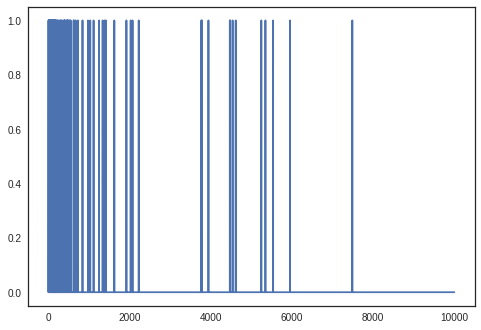

In [3]:
plt.plot(train_data[0])

## 2. Demonstrate Overfitting

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters is a model often referred to as the model's 'capacity'. Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictioinary-like mapping between training samples and their targets, a mapping without any generlization power, but this would bu useless when making predictions on previously unseen data. 

Always keep this in mind, deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting. 

On the other hand, if the network has limited memorizeation resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model to small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity"

Unfortunately, there is no magical formula to determine the right size or architecture of your model. You will have to experiment using a series of different architectures.

To find an appropricate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validaiton loss.

### 2.1 Create a baseline model

In [4]:
baseline_model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])

baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [5]:
baseline_history = baseline_model.fit(train_data,
                                     train_labels,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(test_data,test_labels),
                                     verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.4474 - acc: 0.8206 - binary_crossentropy: 0.4474 - val_loss: 0.3143 - val_acc: 0.8790 - val_binary_crossentropy: 0.3143
Epoch 2/20
 - 3s - loss: 0.2307 - acc: 0.9167 - binary_crossentropy: 0.2307 - val_loss: 0.2843 - val_acc: 0.8865 - val_binary_crossentropy: 0.2843
Epoch 3/20
 - 3s - loss: 0.1715 - acc: 0.9405 - binary_crossentropy: 0.1715 - val_loss: 0.2923 - val_acc: 0.8833 - val_binary_crossentropy: 0.2923
Epoch 4/20
 - 3s - loss: 0.1356 - acc: 0.9549 - binary_crossentropy: 0.1356 - val_loss: 0.3181 - val_acc: 0.8786 - val_binary_crossentropy: 0.3181
Epoch 5/20
 - 3s - loss: 0.1100 - acc: 0.9647 - binary_crossentropy: 0.1100 - val_loss: 0.3449 - val_acc: 0.8740 - val_binary_crossentropy: 0.3449
Epoch 6/20
 - 3s - loss: 0.0868 - acc: 0.9753 - binary_crossentropy: 0.0868 - val_loss: 0.3763 - val_acc: 0.8692 - val_binary_crossentropy: 0.3763
Epoch 7/20
 - 3s - loss: 0.0683 - acc: 0.9825 - binary_crossentropy:

### 2.2 Create a smaller model

In [8]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])

smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [9]:
smaller_history = smaller_model.fit(train_data,
                                     train_labels,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(test_data,test_labels),
                                     verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.6604 - acc: 0.6116 - binary_crossentropy: 0.6604 - val_loss: 0.6234 - val_acc: 0.6876 - val_binary_crossentropy: 0.6234
Epoch 2/20
 - 3s - loss: 0.5819 - acc: 0.7523 - binary_crossentropy: 0.5819 - val_loss: 0.5595 - val_acc: 0.7796 - val_binary_crossentropy: 0.5595
Epoch 3/20
 - 3s - loss: 0.5187 - acc: 0.8269 - binary_crossentropy: 0.5187 - val_loss: 0.5143 - val_acc: 0.8020 - val_binary_crossentropy: 0.5143
Epoch 4/20
 - 3s - loss: 0.4708 - acc: 0.8657 - binary_crossentropy: 0.4708 - val_loss: 0.4805 - val_acc: 0.8395 - val_binary_crossentropy: 0.4805
Epoch 5/20
 - 3s - loss: 0.4341 - acc: 0.8920 - binary_crossentropy: 0.4341 - val_loss: 0.4578 - val_acc: 0.8477 - val_binary_crossentropy: 0.4578
Epoch 6/20
 - 3s - loss: 0.4044 - acc: 0.9080 - binary_crossentropy: 0.4044 - val_loss: 0.4392 - val_acc: 0.8610 - val_binary_crossentropy: 0.4392
Epoch 7/20
 - 3s - loss: 0.3797 - acc: 0.9204 - binary_crossentropy:

### 2.3 Create a bigger model

In [10]:
bigger_model = keras.Sequential([
    keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])

bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


In [11]:
bigger_history = bigger_model.fit(train_data,
                                     train_labels,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(test_data,test_labels),
                                     verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 4s - loss: 0.3463 - acc: 0.8544 - binary_crossentropy: 0.3463 - val_loss: 0.2934 - val_acc: 0.8818 - val_binary_crossentropy: 0.2934
Epoch 2/20
 - 4s - loss: 0.1374 - acc: 0.9502 - binary_crossentropy: 0.1374 - val_loss: 0.3517 - val_acc: 0.8641 - val_binary_crossentropy: 0.3517
Epoch 3/20
 - 4s - loss: 0.0445 - acc: 0.9876 - binary_crossentropy: 0.0445 - val_loss: 0.4367 - val_acc: 0.8673 - val_binary_crossentropy: 0.4367
Epoch 4/20
 - 4s - loss: 0.0072 - acc: 0.9989 - binary_crossentropy: 0.0072 - val_loss: 0.5795 - val_acc: 0.8715 - val_binary_crossentropy: 0.5795
Epoch 5/20
 - 4s - loss: 9.5740e-04 - acc: 0.9999 - binary_crossentropy: 9.5740e-04 - val_loss: 0.6702 - val_acc: 0.8725 - val_binary_crossentropy: 0.6702
Epoch 6/20
 - 4s - loss: 2.2870e-04 - acc: 1.0000 - binary_crossentropy: 2.2870e-04 - val_loss: 0.7103 - val_acc: 0.8713 - val_binary_crossentropy: 0.7103
Epoch 7/20
 - 4s - loss: 1.3036e-04 - acc: 1.0000 - 

### 2.4 Plot the training and validation loss

The solid lines shows the training loss, and the dashed lines show the validation loss.

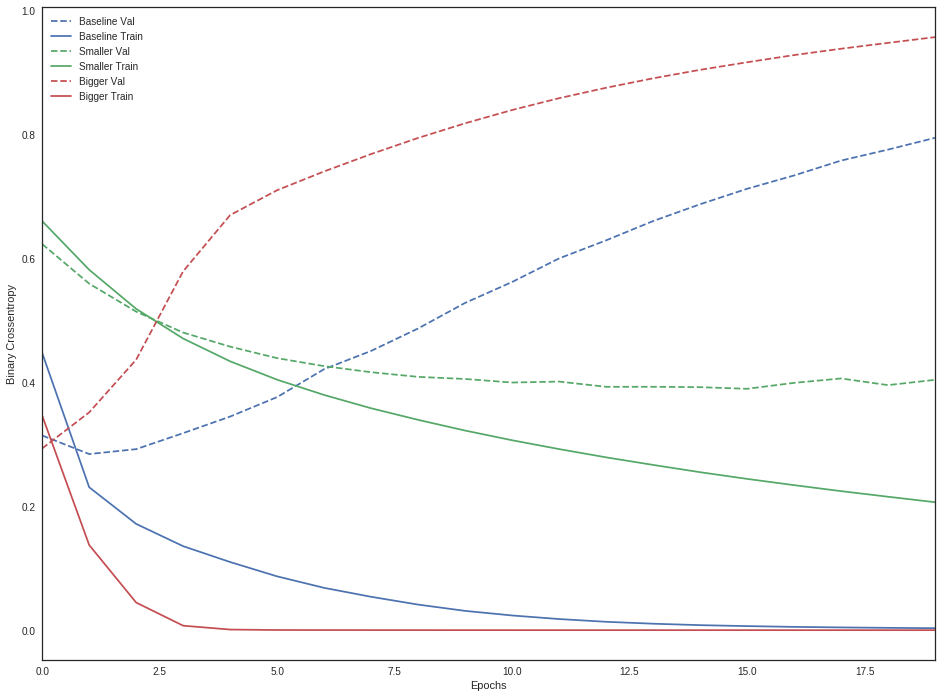

In [12]:
def plot_history(histories, key='binary_crossentropy'):
    plt.figure(figsize=(16,12))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                      '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key],color=val[0].get_color(),
                label=name.title()+' Train')
        
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    
    plt.xlim([0, max(history.epoch)])
    
    
plot_history([('baseline',baseline_history),
             ('smaller',smaller_history),
             ('bigger',bigger_history)])

Notice that the larger network begins overfitting almost right away, after just one epoch, and overfits much more severely. The more capacity the network has, the quicker it will be able to model the training data, but the more susceptible it is to overfitting

## 3. Strategies

### 3.1 Add weight regularization

A "simple model" in this context is a model where the distribution of parameter values has less entropy. Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two falvors:

* L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients

* L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients . L2 regularization is also called weight decay in the context of neural networks.

In [13]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                      activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001),
                      activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy','binary_crossentropy'])

l2_model_history = l2_model.fit(train_data, train_labels,
                               epochs=20,
                               batch_size=512,
                               validation_data=(test_data,test_labels),
                               verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.5218 - acc: 0.8059 - binary_crossentropy: 0.4796 - val_loss: 0.3784 - val_acc: 0.8774 - val_binary_crossentropy: 0.3328
Epoch 2/20
 - 3s - loss: 0.3035 - acc: 0.9100 - binary_crossentropy: 0.2533 - val_loss: 0.3378 - val_acc: 0.8871 - val_binary_crossentropy: 0.2845
Epoch 3/20
 - 3s - loss: 0.2541 - acc: 0.9297 - binary_crossentropy: 0.1986 - val_loss: 0.3429 - val_acc: 0.8852 - val_binary_crossentropy: 0.2858
Epoch 4/20
 - 3s - loss: 0.2294 - acc: 0.9410 - binary_crossentropy: 0.1708 - val_loss: 0.3589 - val_acc: 0.8806 - val_binary_crossentropy: 0.2995
Epoch 5/20
 - 3s - loss: 0.2175 - acc: 0.9459 - binary_crossentropy: 0.1566 - val_loss: 0.3706 - val_acc: 0.8779 - val_binary_crossentropy: 0.3088
Epoch 6/20
 - 3s - loss: 0.2049 - acc: 0.9513 - binary_crossentropy: 0.1426 - val_loss: 0.3870 - val_acc: 0.8743 - val_binary_crossentropy: 0.3245
Epoch 7/20
 - 3s - loss: 0.1981 - acc: 0.9546 - binary_crossentropy:

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001*weight_coefficent_value` to the total loss of the network. Note that because this penalty is only added at training time, the loss for this network will be much higher at training than at test time

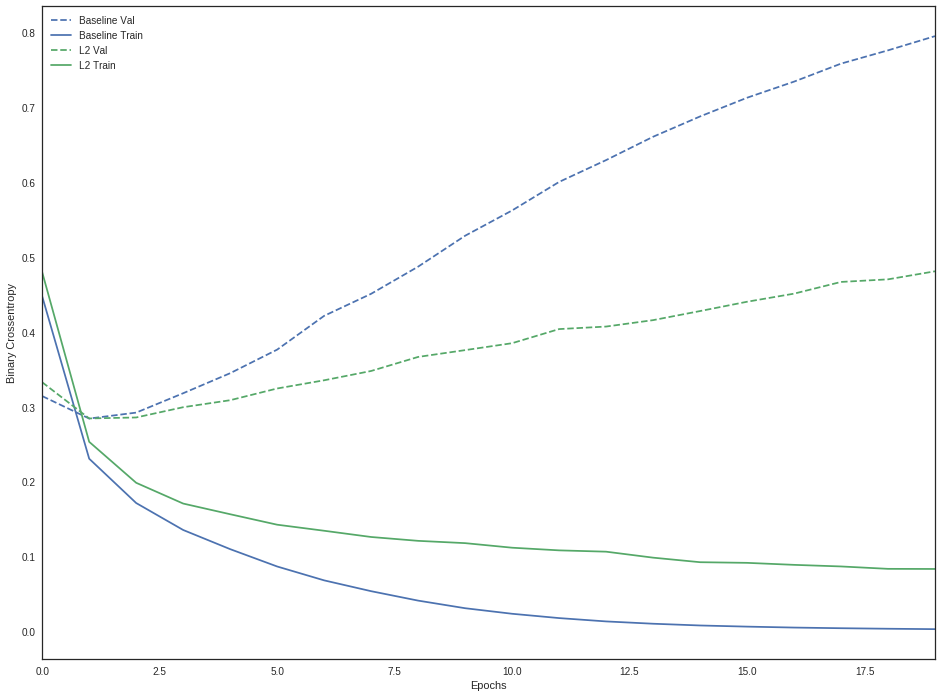

In [15]:
plot_history([('baseline',baseline_history),
             ('l2',l2_model_history)])    

As we can see, the L2 regularized model has become much more resistant to overfitting that the baseline model, even though both models have the same number of parameters

### 3.2 Add Dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output of the layer during training.

In [17]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data, train_labels,
                                 epochs=20, batch_size=512,
                                 validation_data=(test_data,test_labels),
                                 verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 3s - loss: 0.6287 - acc: 0.6424 - binary_crossentropy: 0.6287 - val_loss: 0.5029 - val_acc: 0.8464 - val_binary_crossentropy: 0.5029
Epoch 2/20
 - 3s - loss: 0.4643 - acc: 0.8012 - binary_crossentropy: 0.4643 - val_loss: 0.3492 - val_acc: 0.8802 - val_binary_crossentropy: 0.3492
Epoch 3/20
 - 3s - loss: 0.3604 - acc: 0.8640 - binary_crossentropy: 0.3604 - val_loss: 0.2951 - val_acc: 0.8877 - val_binary_crossentropy: 0.2951
Epoch 4/20
 - 3s - loss: 0.2981 - acc: 0.8970 - binary_crossentropy: 0.2981 - val_loss: 0.2759 - val_acc: 0.8887 - val_binary_crossentropy: 0.2759
Epoch 5/20
 - 3s - loss: 0.2557 - acc: 0.9127 - binary_crossentropy: 0.2557 - val_loss: 0.2752 - val_acc: 0.8880 - val_binary_crossentropy: 0.2752
Epoch 6/20
 - 3s - loss: 0.2297 - acc: 0.9249 - binary_crossentropy: 0.2297 - val_loss: 0.2848 - val_acc: 0.8863 - val_binary_crossentropy: 0.2848
Epoch 7/20
 - 3s - loss: 0.2018 - acc: 0.9338 - binary_crossentropy:

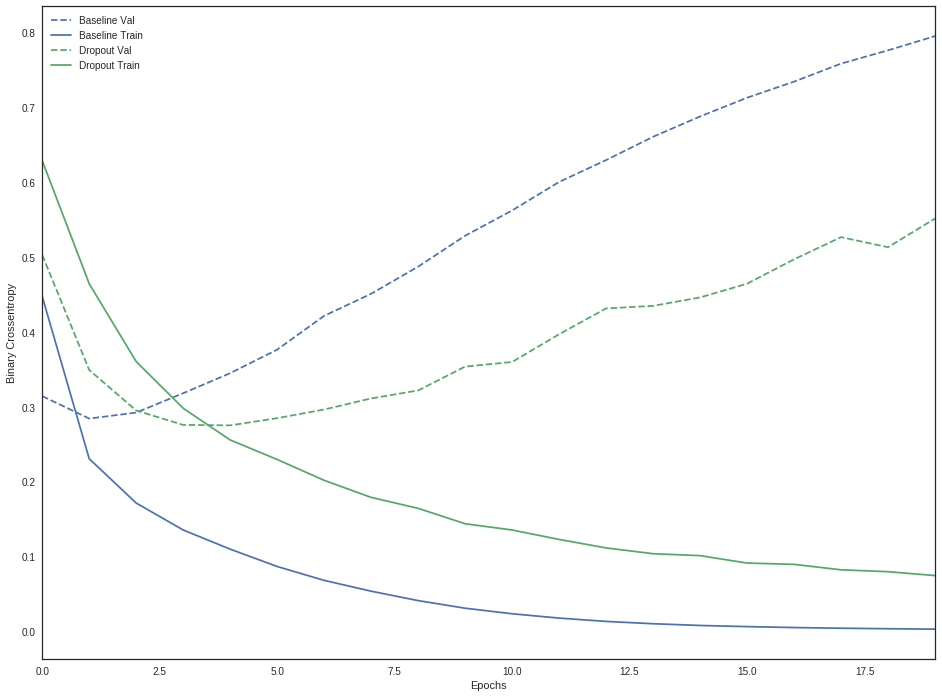

In [18]:
plot_history([('baseline',baseline_history),
             ('dropout',dpt_model_history)])

Adding dropout is a clear improvement over the baseline model.

To recap: here are most common ways to prevent overfitting in a neural networks:

* Get more training data

* Reduce capacity of the network

* Add weight regularization

* Add dropout